In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statistics
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV

# Import data 

The following data was preprocessed in R, by merging eset_HTA20 and anoSC1_v11_nokey.csv

In [2]:
alldata = pd.read_csv("alldata.csv")

Check the data

In [3]:
alldata.head()

,Unnamed: 0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,g_32827,g_32828,g_32829,g_32830,SampleID,GA,Batch,Set,Train,Platform
0,1,6.062215,3.796484,5.849338,3.567779,6.166815,4.443027,5.836522,6.330018,4.922339,...,8.972873,10.440245,12.101476,13.695705,Tarca_001_P1A01,11.0,1,PRB_HTA,1,HTA20
1,2,6.125023,3.805305,6.191562,3.452524,5.678373,4.773199,6.143398,5.601745,4.711765,...,9.376194,10.845176,12.370891,13.635522,Tarca_003_P1A03,NaN,1,PRB_HTA,0,HTA20
2,3,5.875502,3.450245,6.550525,3.316134,6.185059,4.393488,5.898364,6.137984,4.628124,...,8.843612,10.493416,12.295786,13.616688,Tarca_004_P1A04,32.6,1,PRB_HTA,1,HTA20
3,4,6.126131,3.628411,6.421877,3.432451,5.633757,4.623783,6.019792,5.787502,4.796283,...,9.191471,10.879879,12.249936,13.524328,Tarca_005_P1A05,30.6,1,PRB_HTA,1,HTA20
4,5,6.146466,3.446812,6.260962,3.477162,5.313198,4.422651,6.407699,5.830437,4.726488,...,9.247768,10.754316,12.245458,13.509353,Tarca_006_P1A06,NaN,1,PRB_HTA,0,HTA20


# Make train and test dataset

In [4]:
X_train = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830'].values
X_train_df = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']

In [5]:
y_train = alldata.loc[alldata['Train'] == 1, 'GA'].values
y_train_df = alldata.loc[alldata['Train'] == 1, 'GA']

In [46]:
# X_test = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830'].values
X_test_df = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830']
ID_test = alldata.loc[alldata['Train'] == 0, 'SampleID'].values

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(367, 32830)
(367,)
(368, 32830)


# EDA

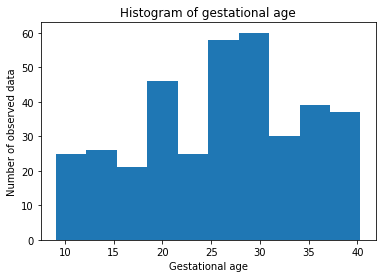

In [8]:
_ = plt.hist(y_train)
_ = plt.xlabel("Gestational age")
_ = plt.ylabel("Number of observed data")
_ = plt.title("Histogram of gestational age")
plt.show()

# Lasso regression

(32830,)
[ 0.  0. -0. -0. -0.]
[-0. -0. -0. -0. -0.]


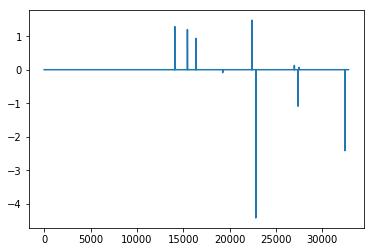

In [9]:
alpha = 0.1
lasso = Lasso(alpha = alpha, normalize = True)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
print(lasso_coef.shape)
print(lasso_coef[0:5])
print(lasso_coef[32825:32831])
_ = plt.plot(lasso_coef)
plt.show()

In [10]:
COLUMNS = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830'].columns
var = pd.Series(COLUMNS[abs(lasso_coef) > 0.5])
coef = pd.Series(lasso_coef[abs(lasso_coef) > 0.5])
lasso_result = pd.concat(objs = [var, coef],
                         axis = 1,
                         keys = ['Variable', 'Lasso_coefficient'])
print(lasso_result)

  Variable  Lasso_coefficient
0  g_14088           1.287940
1  g_15452           1.197929
2  g_16391           0.931973
3  g_22398           1.476096
4  g_22824          -4.424946
5  g_27389          -1.089270
6  g_32432          -2.418021


# Trial prediction

DREAM rules predicted gestational age in fractional weeks up to one decimal place.

In [24]:
COLUMNS = lasso_result['Variable'].tolist()
X = X_train_df[COLUMNS].values
y = y_train
model = LinearRegression()
model.fit(X, y)
train_pred = model.predict(X).round(1)
result = pd.concat([pd.Series(y_train), pd.Series(train_pred)], 
                   axis = 1,
                   keys = ['GA_act', 'GA_pred'])
result.head()

,GA_act,GA_pred
0,11.0,12.2
1,32.6,33.4
2,30.6,23.6
3,26.1,22.6
4,22.6,24.6


# Training accuracy

DREAM judges by Root Mean Squared Error.

In [29]:
math.sqrt(statistics.mean((result['GA_act'] - result['GA_pred'])**2))

6.425040421208954

# Prediction in test data

In [47]:
COLUMNS = lasso_result['Variable'].tolist()
X_test = X_test_df[COLUMNS].values
test_pred = model.predict(X_test).round(1)
result = pd.concat([pd.Series(ID_test), pd.Series(test_pred)],
                  axis = 1,
                  keys = ['SampleID', 'GA'])
result.head()

,SampleID,GA
0,Tarca_003_P1A03,27.4
1,Tarca_006_P1A06,25.4
2,Tarca_011_P1A11,22.9
3,Tarca_012_P1A12,35.9
4,Tarca_015_P1B03,25.4


In [48]:
result['GA'].describe()

count    368.000000
mean      26.029076
std        5.683093
min        8.100000
25%       22.550000
50%       26.200000
75%       29.925000
max       42.800000
Name: GA, dtype: float64

# Adjustment

DREAM suggests that values are expected to be >8 and <42, so adjusts predicted values.
<br>
https://www.synapse.org/#!Synapse:syn18380862/wiki/590817

In [51]:
(result['GA'] >= 42).sum()

1

In [62]:
result.loc[result['GA'] >= 42, 'GA'] = 42

In [63]:
result.iloc[350]

SampleID    Tarca_844_P8D10
GA                       42
Name: 350, dtype: object

In [64]:
result['GA'].describe()

count    368.000000
mean      26.026902
std        5.676810
min        8.100000
25%       22.550000
50%       26.200000
75%       29.925000
max       42.000000
Name: GA, dtype: float64

# Export prediction

In [65]:
sub = result

In [66]:
sub.to_csv('C:\\Users\\yukic\\Documents\\DREAM\\submission_190707.csv', index = False)